In [1]:
import pymust, tqdm
import numpy as np, matplotlib.pyplot as plt

# A QUICK START DEMO - simulations, demodulation, beamforming, compounding

In this quick'n easy tutorial, it is shown how to simulate an ultrasound image from the transmit of plane waves. A few scatterers will be insonified with steered planes waves to obtain a compound image. You will use the following fundamental steps:

 1.   A transducer will be chosen with GETPARAM,
1. Transmit delays will be designed with TXDELAY
1.    A pressure field will be calculated with PFIELD
1.   RF signals will be simulated with the function SIMUS.
1.   The RF signals will be I/Q demodulated with RF2IQ,
1.    then beamformed with DAS.
1.    A compound image will eventually be generated.

## Scatterers
Define a few scatterers with their reflective coefficients

In [2]:
xs = np.array([1.7, 1.3, 0.7, 0, -0.7, -1.3, -1.7, 0, -1, 1])*1e-2;  # in m
zs = np.array([2.8, 3.2, 3.5, 3.6, 3.5, 3.2, 2.8, 2, 0.8, 0.8])*1e-2 # in m
RC = np.ones(xs.shape)

## Select a transducer with GETPARAM

We want a 128-element linear array.

In [3]:
param = pymust.getparam('L11-5v')

The structure param contains the tranducer properties.

## Design the transmit delays with TXDELAY

The scatterers will be insonified with 21 plane waves steered at -10 to +10 degrees. Use TXDELAY to calculate the transmit delays for the 21 plane waves.


In [4]:
tilt = np.linspace(-10,10,21)/180*np.pi; # tilt angles in rad
tilt = [0]
txdel = np.array([pymust.txdelay(param, t) for t in tilt])

In [5]:
txdel.shape

(1, 1, 128)

# Check a pressure field with PFIELD

Let us visualize the 5th pressure field.

Define a 100 $\times$ 100 8-cm-by-8-cm grid.

In [6]:
x_extent = np.linspace(-4e-2,4e-2,100)
y_extent = np.linspace(0,8e-2,100)
xi,zi = np.meshgrid(x_extent, y_extent);

We will consider elevation focusing. We thus also need y-coordinates to force the use of the 3-D acoustic equations. Here, they are all 0.

In [7]:
yi = np.zeros(xi.shape)

In [61]:
xi.shape,yi.shape,zi.shape

((100, 100), (100, 100), (100, 100))

Simulate the pressure field.


In [63]:
average_function_by_i = [None] * 10
average_function_by_i[1] = lambda X: (X[...,0])/1
average_function_by_i[2] = lambda X: (X[...,0]+X[...,1])/2
average_function_by_i[3] = lambda X: (X[...,0]+X[...,1]+X[...,2])/3
average_function_by_i[4] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3])/4
average_function_by_i[5] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4])/5
average_function_by_i[6] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5])/6
average_function_by_i[7] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5]+X[...,6])/7
average_function_by_i[8] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5]+X[...,6]+X[...,7])/8
average_function_by_i[9] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5]+X[...,6]+X[...,7]+X[...,8])/9


def average_over_last_axis(X):
    if X.shape[-1] < len(average_function_by_i):
        return average_function_by_i[X.shape[-1] ](X)
    else:
        return np.mean(X, axis = -1)
    
MoyenneSousElemPiezo = average_over_last_axis

def pfield(x : np.ndarray,y : np.ndarray,z : np.ndarray,DelaiEmissionElemPiezo  : np.ndarray,param):
    FrequencyStep = 1 # coef de diffusion
    RP = 0 # RP = Radiation Pattern
    # RP = np.zero((-1,param.Nelements, delaysTX.shape[0] )) 
    RadiusOfCurvature = param.radius
    c = 1540 # % default value of sound speed
    OriginalShape = x.shape

    # FREQUENCY SAMPLES
    # param.fc = central frequency (Hz)
    Nf = int( 2* np.ceil( param.fc )+1) # number of frequency samples
    Nf = 10000
    f = np.linspace(0,2*param.fc,Nf) # frequency samples
    nSampling = len(f)

    # Position des elements de la sonde
    # THe = angle of the normal to element with respect to the z-axis
    ElementWidth = param.width
    NumberOfElements = param.Nelements
    PositionsCentresElemPiezo_x, PositionsCentresElemPiezo_z, AngleNormalElemPiezo, _ = param.getElementPositions()
    # AngleNormalElemPiezo = 0
    PositionsCentresElemPiezo_x = PositionsCentresElemPiezo_x.reshape((1,NumberOfElements,1))
    PositionsCentresElemPiezo_z = PositionsCentresElemPiezo_z.reshape((1,NumberOfElements,1))

    ResolutionSpatiale = c/(param.fc*(1+param.bandwidth/200))

    NbSousElemPiezo = int(np.ceil(ElementWidth/ResolutionSpatiale))
    #NbSousElemPiezo=1
    SizeSousElemPiezo = ElementWidth/NbSousElemPiezo

    PositionsCentresSousElemPiezo = -ElementWidth/2 + SizeSousElemPiezo/2 + np.arange(NbSousElemPiezo)*SizeSousElemPiezo
    PositionsCentresSousElemPiezo = PositionsCentresSousElemPiezo.reshape((1,1,NbSousElemPiezo)) # une valeur x,z pour chaque SousElemPiezo

    PositionsCentresSousElemPiezo_x = PositionsCentresSousElemPiezo*np.cos(AngleNormalElemPiezo)[:,:,np.newaxis]
    PositionsCentresSousElemPiezo_z = PositionsCentresSousElemPiezo*np.sin(-AngleNormalElemPiezo)[:,:,np.newaxis]

   
    #%-- Coordinates of the points where pressure is needed
    x = x.reshape((-1,1,1)).astype(np.float32)
    y = y.reshape((-1,1,1)).astype(np.float32)
    z = z.reshape((-1,1,1)).astype(np.float32)


    FreqSweep = param.TXfreqsweep
    #%-- FREQUENCY SPECTRUM of the transmitted pulse
    pulseSpectrum = param.getPulseSpectrumFunction(FreqSweep)
    #%-- FREQUENCY RESPONSE of the ensemble PZT + probe
    probeSpectrum = param.getProbeFunction()
    pulseSPECT = pulseSpectrum(2*np.pi*f) # pulse spectrum
    probeSPECT = probeSpectrum(2*np.pi*f) # probe 

  
    # valeurs de RP pour chaque point de la grille pour chaque sous element piezo de chaque elem de la sonde 
    dxi = x.reshape((-1,1,1)) - PositionsCentresSousElemPiezo_x - PositionsCentresElemPiezo_x
    dzi = z.reshape((-1,1,1)) - PositionsCentresSousElemPiezo_z - PositionsCentresElemPiezo_z
    dyi = y.reshape((-1,1,1))
    r2 = dxi**2 + dzi**2 + dyi**2 # pythagore 3d

    # Pas de limite inferieure de resolution spatiale
    # Tout peut etre aussi petit que cenessaire, pas de probleme
    # smallD2 = ResolutionSpatiale**2
    # d2[d2<smallD2] = smallD2

    r = np.sqrt(r2).astype(np.float32) # distance between the segment centroid and the point of interest
    # On considere que la frequemce est independente de la direction du signal emis/recu. Ne depend uniquement de la distance (r)
    # Th = np.arcsin(dxi/r)-AngleNormalElemPiezo.reshape((1,-1,1))
    del r2

    # # %-- EXPONENTIAL arrays of size [numel(x) NumberOfElements M]
    wavenumber = 2*np.pi*f[0]/c # % wavenumber
    kwa = 0 # % attenuation-based wavenumber; no attenuation -> 0
    # EXP = np.exp(-kwa*r + 1j*np.mod(kw*r,2*np.pi)).astype(np.complex64) #; % faster than exp(-kwa*r+1j*kw*r)
    EXP = np.exp(-kwa*r+1j*wavenumber*r).astype(np.complex64)

    dkw = 2*np.pi*FrequencyStep/c
    dkwa = 0
    delta_EXP = np.exp(-dkwa*r + 1j*dkw*r).astype(np.complex64)

    del r
    
    for k  in tqdm.tqdm(range(nSampling)):

        wavenumber_k = 2*np.pi*f[k]/c #; % wavenumber

        EXP = EXP*delta_EXP

        ValeurElemPiezo = MoyenneSousElemPiezo(EXP); #% summation over the M small segments
        
        DelaiEmissionElemPiezo = DelaiEmissionElemPiezo.astype(np.float32)

        APOD = 1 # pas d'apodization -> APOD=1
        DELAPOD = APOD * np.sum(np.exp(1j*wavenumber_k*c*DelaiEmissionElemPiezo), 0).reshape((-1, 1)) # force (NumberofElements,1)

        RPk = np.matmul(ValeurElemPiezo, DELAPOD) #somme des radiation pattern de chaque élément
        
        RPk = pulseSPECT[k]*probeSPECT[k]*RPk #%- include spectrum responses:

        RP += np.abs(RPk)**2


    RP = np.sqrt(RP); #% acoustic intensity, RPk est le radiation pattern de chaque élément

    CorrectingFactor = FrequencyStep
    RP = RP*CorrectingFactor
    return RP.reshape(OriginalShape)

P = pfield(xi,yi,zi,txdel[0],param);

100%|██████████| 10000/10000 [02:42<00:00, 61.54it/s]


In [8]:
from importlib import reload
reload(pymust)
P0, _, _ = pymust.pfield(xi,yi,zi,txdel[0],param);


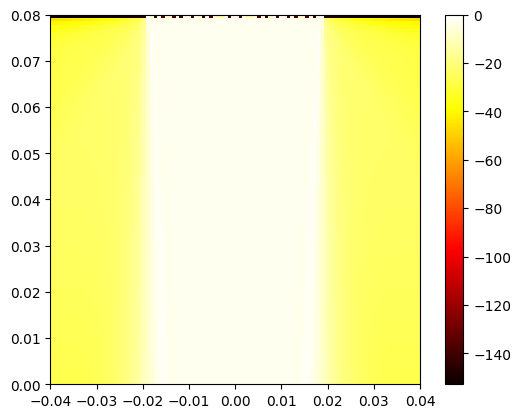

In [69]:
plt.imshow(20 * np.log10(P0 / np.max(P0)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()

In [64]:
m,M = np.min(P),np.max(P)
m,M

(7193.874, 7371.423)

In [65]:
P2 = (P-m)/(M-m)*255

Display the 5th pressure field.

c:\Users\tlali\OneDrive\Documents\ProjetS9\.venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


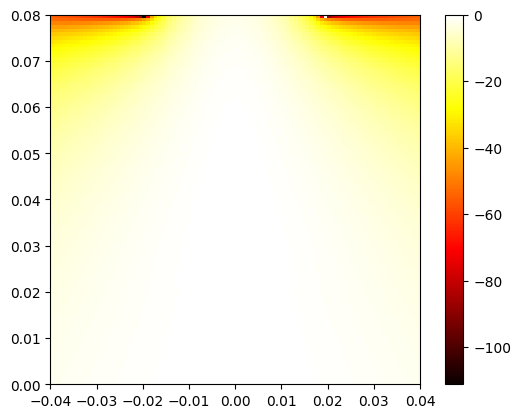

In [66]:
plt.imshow(20 * np.log10(P2 / np.max(P2)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()

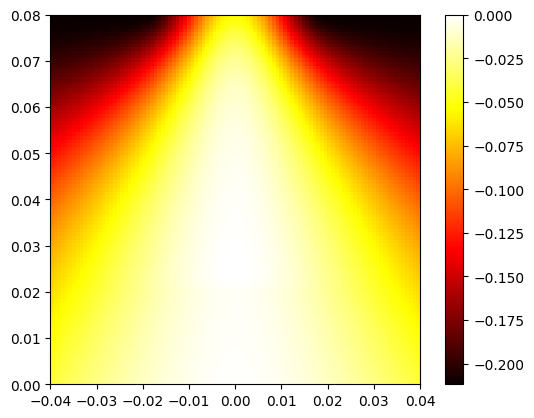

In [67]:
plt.imshow(20 * np.log10(P / np.max(P)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()

# Simulate RF signals with SIMUS

We will now simulate 21 series of RF signals. Each series will contain 128 RF signals, as the simulated linear array contains 128 elements.

In [ ]:
RF = [] # this array will contain the RF series
param.fs = 4*param.fc; # sampling frequency in Hz
for k,t in tqdm.tqdm(enumerate(txdel)):
    r, _ = pymust.simus(xs,zs,RC,t, param)
    RF.append(r)


This is the 64th RF signal of the 1st series:

In [ ]:
rf = RF[0][:,63]
t = np.arange(len(rf))/param.fs*1e6 #% time (ms)
plt.plot(t,rf)
plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the $64^{th}$ element ($1^{st}$ series, tilt = $-20{\circ}$)')


## Demodulate the RF signals with RF2IQ

Before beamforming, the RF signals must be I/Q demodulated.

In [ ]:
IQ = [] #  % this cell will contain the I/Q series

for r in RF:
    IQ.append(pymust.rf2iq(r,param.fs,param.fc))


In [ ]:
iq = IQ[0][:,63];
plt.plot(t,np.real(iq), label = 'in-phase')
plt.plot(t,np.imag(iq), label = 'quadrature')
plt.xlabel('time (\mus)')
plt.title('I/Q signal of the 64^{th} element (1^{st} series, tilt = -10{\circ})')
plt.legend()


## Beamform the I/Q signals with DAS

It is recommended to use an adequate receive f-number when beamforming. Define a void f-number; it will be determined automatically by DAS from the element directivity.

Define a 200 $\times$ 200 4-cm-by-4-cm image grid.

In [ ]:
x_extent = np.linspace(-2e-2,2e-2,200)
z_extent = np.linspace(0,4e-2,200)
PositionsCentresSousElemPiezo_x,PositionsCentresElemPiezo_z = np.meshgrid(x_extent, z_extent)

In [ ]:
p = param.copy()


In [ ]:
pymust.dasmtx(IQ[k], PositionsCentresSousElemPiezo_x,PositionsCentresElemPiezo_z, p)

In [ ]:
bIQ = np.zeros((*PositionsCentresSousElemPiezo_x.shape, len(txdel)), dtype = np.complex64)  #% this array will contain the 21 I/Q images

for k, t in enumerate(txdel):
    param.TXdelay = t
    q = (pymust.dasmtx(IQ[k], PositionsCentresSousElemPiezo_x,PositionsCentresElemPiezo_z, param) @ IQ[k].flatten(order = 'F')).reshape(PositionsCentresSousElemPiezo_x.shape,order = 'F')
    bIQ[:,:,k] = q


## Compound ultrasound image

An ultrasound image is obtained by log-compressing the amplitude of the beamformed I/Q signals. Have a look at the images obtained when steering at -10 degrees.

In [ ]:
I = pymust.bmode(bIQ[:,:,0],40) # log-compressed image
plt.imshow(I, cmap = 'gray', extent = [PositionsCentresSousElemPiezo_x[0,0], PositionsCentresSousElemPiezo_x[0,-1], PositionsCentresElemPiezo_z[0,0], PositionsCentresElemPiezo_z[-1,-1]])
plt.title('PW-based echo image with a tilt angle of -10{\circ}')
plt.axis('equal')
plt.ylabel('[cm]')
plt.colorbar()


The individual images are of poor quality. Generate a compound image with the series of 21 diverging waves steered at different angles.

In [ ]:
cIQ = np.sum(bIQ,2) # this is the compound beamformed I/Q
I = pymust.bmode(cIQ,40); #log-compressed image
plt.imshow(I, cmap = 'gray', extent = [PositionsCentresSousElemPiezo_x[0,0], PositionsCentresSousElemPiezo_x[0,-1], PositionsCentresElemPiezo_z[0,0], PositionsCentresElemPiezo_z[-1,-1]])
plt.colorbar()
#plt.clim(-40,0)
plt.axis('equal')
plt.ylabel('[cm]')
plt.title('Compound PW-based echo image')


# MKmovie

Test creating a movie using the mkmovie function

*Note G.Bernardino, TODO:* this is considerably slower than the matlab version. Investigate why

In [ ]:
param.attenuation = 0.0
txdel_0 = np.zeros((1,param.Nelements))
opt = pymust.utils.Options()
opt.plotScatterers = True
F,info, param = pymust.mkmovie(xs, zs, RC,txdel_0,param, opt, 'noAttenuation.gif');

In [ ]:
opt

In [ ]:
param.attenuation = 0.5
txdel_0 = np.zeros((1,param.Nelements))
F,info, param = pymust.mkmovie(xs, zs, RC,txdel_0,param, 'attenuation.gif');